In [10]:
!nvcc --version
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

%load_ext nvcc_plugin


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-qhnam6jq
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-qhnam6jq
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=2d919e03bdc44e99128891ce064239984cdedb69a325d0da4eeb44a7ca2b0374
  Stored in directory: /tmp/pip-ephem-wheel-cache-9bqyobf_/wheels/c5/2b/c0/87008e795a14bbcdfc7c846a00d06981916331eb980b6c8bdf
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


1 loop, best of 5: 3.09 s per loop


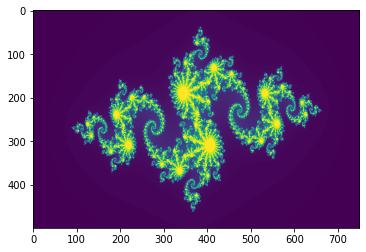

In [3]:
def julia(x, y, max_iters):
  i = 0
  c = complex(-0.8, 0.156)
  a = complex(x,y)
  for i in range(max_iters):
    a = a*a + c
    if (a.real*a.real + a.imag*a.imag) > 1000:
      return int((i/max_iters)*255)
  return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = julia(real, imag, iters)
      image[y, x] = color

  return image

import numpy as np
import matplotlib.pyplot as plt
image = np.zeros((500, 750), dtype=np.uint8)
%timeit create_fractal(-2.0, 2.0, -1.0, 1.0, image, 200)
plt.imshow(image)
plt.viridis()
plt.show()


The slowest run took 46.67 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 14.7 ms per loop


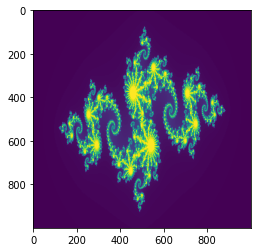

In [32]:
from numba import cuda
@cuda.jit(device=True)
def julia(x, y, max_iters):
  i = 0
  c = complex(-0.8, 0.156)
  a = complex(x,y)
  for i in range(max_iters):
    a = a*a + c
    if (a.real*a.real + a.imag*a.imag) > 1000:
      return int((i/max_iters)*255)
  return 255

threadsperblock = 16
xblocks = (image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (image.shape[0] + (threadsperblock - 1)) // threadsperblock

@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  x, y = cuda.grid(2)
    
  if x < width and y < height:
    real = min_x + x * pixel_size_x
    imag = min_y + y * pixel_size_y
    color = julia(real, imag, iters)
    image[y, x] = color

image = np.zeros((1000, 1000), dtype=np.uint8)
threadsperblock = 16
threads_per_block = (16, 16)
xblocks = (image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (image.shape[0] + (threadsperblock - 1)) // threadsperblock
blocks_per_grid = (xblocks, yblocks)

%timeit create_fractal[blocks_per_grid, threads_per_block](-2.0, 2.0, -1.0, 1.0, image, 200)
plt.imshow(image)
plt.viridis()
plt.show()


In [46]:
%%cu
#define N 500000
#include <stdio.h>
#include <time.h>
void add( int *a, int *b, int *c ) {
int tid = 0; // to jest CPU nr zero, a więc zaczynamy od zera
while (tid < N) {
c[tid] = a[tid] * b[tid];
tid += 1; // mamy tylko jeden CPU, a więc zwiększamy o jeden
  }
}
int main( void ) {
int a[N], b[N], c[N];
clock_t start, end;
// zapelnianie tablic a i b za pomocą CPU
for (int i=0; i<N; i++) {
a[i] = -i;
b[i] = i * i;
}
start = clock();
add( a, b, c );
end = clock();
double CPU = ((double)(end-start))/CLOCKS_PER_SEC;
printf("CPU: %lf sekund \n", CPU);
return 0;
}


CPU: 0.008032 sekund 



In [45]:
%%cu
#define N 500000
#include <stdio.h>
#include <time.h>
__global__ void add( int *a, int *b, int *c ) {
int tid = blockIdx.x; // dodawanie na danych znajdujących się pod indeksem
if (tid < N)
c[tid] = a[tid] * b[tid];
}

int main( void ) {
int a[N], b[N], c[N];
int *dev_a, *dev_b, *dev_c;
// alokacja pamięci na GPU
cudaMalloc( (void**)&dev_a, N * sizeof(int) );
cudaMalloc( (void**)&dev_b, N * sizeof(int) );
cudaMalloc( (void**)&dev_c, N * sizeof(int) );
// zapelnienie tablic a i b na CPU
for (int i=0; i<N; i++) {
a[i] = -i;
b[i] = i * i;
}
// kopiowanie tablic a i b do GPU
clock_t start, end;
start = clock();
cudaMemcpy( dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice );
cudaMemcpy( dev_b, b, N * sizeof(int), cudaMemcpyHostToDevice );
add<<<N,1>>>( dev_a, dev_b, dev_c );
// kopiowanie tablicy c z GPU do CPU
cudaMemcpy( c, dev_c, N * sizeof(int), cudaMemcpyDeviceToHost );
// zwolnienie pamieci alokowanej na CPU
cudaFree( dev_a );
cudaFree( dev_b );
cudaFree( dev_c );
end = clock();
double GPU = ((double)(end-start))/CLOCKS_PER_SEC;
printf("GPU: %lf sekund \n", GPU);
return 0;
}


GPU: 0.004044 sekund 

